# Rossmann Store Sales

https://www.kaggle.com/c/rossmann-store-sales

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from pandas import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pylab import rcParams
rcParams['figure.figsize'] = 14, 20

In [2]:
from pyecharts import options as opts
from pyecharts.charts import Calendar, Bar, Line, Pie, Map, Page, ThemeRiver, Timeline, Grid, Kline, TreeMap, WordCloud, Scatter, EffectScatter
from pyecharts.components import Table
from pyecharts.options import ComponentTitleOpts
from pyecharts.commons.utils import JsCode
from pyecharts.globals import SymbolType

## Load dataset

In [3]:
train = pd.read_csv('data/rossmann-store-sales/train.csv', parse_dates = True, index_col = 'Date')
store = pd.read_csv('data/rossmann-store-sales/store.csv')

In [4]:
print('In total: ', train.shape)

In total:  (1017209, 8)


In [5]:
train.head(5).append(train.tail(5))

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


## Exploratory analysis

In [6]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

In [7]:
train['SalePerCustomer'] = train['Sales']/train['Customers']

In [8]:
train.Store.nunique()

1115

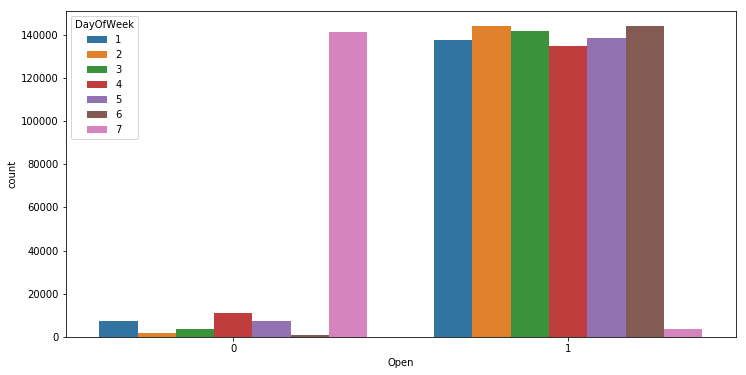

In [9]:
fig, axis = plt.subplots(1, 1, figsize = (12, 6))
sns.countplot(x = 'Open', hue = 'DayOfWeek', data = train)

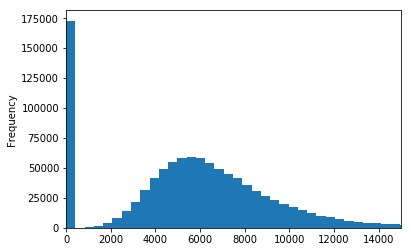

In [10]:
train['Sales'].plot(kind = 'hist', bins = 100, xlim = (0, 15000))

### Empirical cumulative distribution function

Text(0, 0.5, 'ECDF')

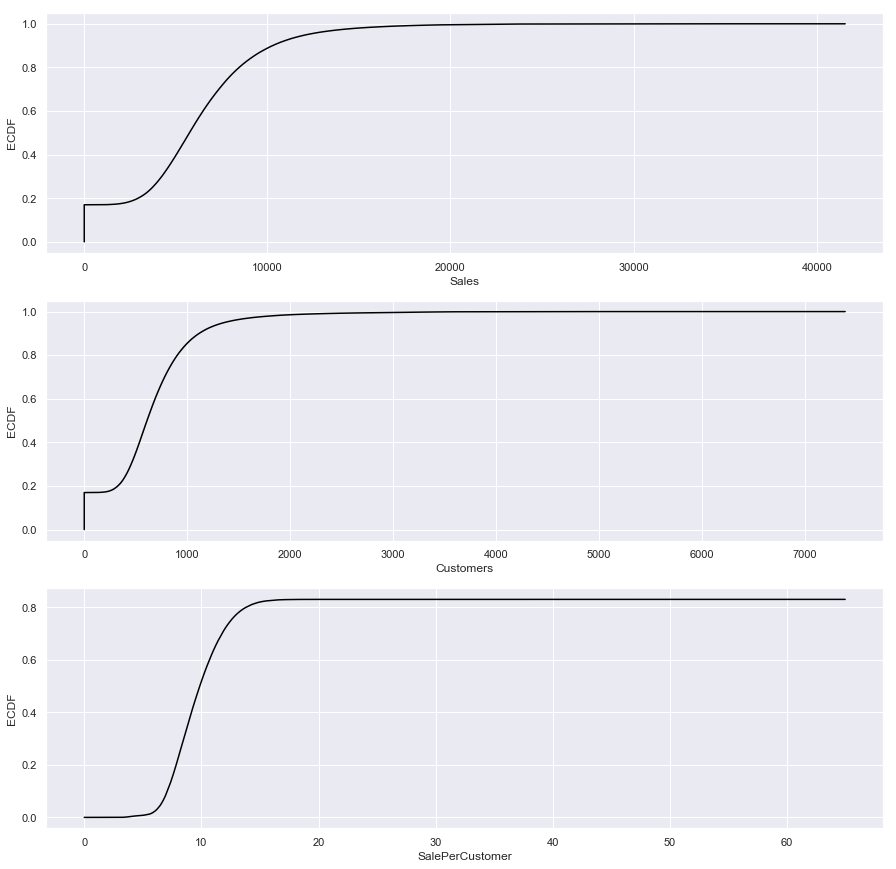

In [11]:
sns.set()
plt.figure(figsize = (15, 15))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, color = 'black')
plt.xlabel('Sales')
plt.ylabel('ECDF')

plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, color = 'black')
plt.xlabel('Customers')
plt.ylabel('ECDF')

plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, color = 'black')
plt.xlabel('SalePerCustomer')
plt.ylabel('ECDF')

### Imputation

In [12]:
train[(train.Open == 0) & (train.Sales == 0)].shape

(172817, 13)

In [13]:
# The store is open, but the sales is zero

zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print('In total: ', zero_sales.shape)

In total:  (54, 13)


In [14]:
zero_sales.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [15]:
train[(train.Open == 0) & (train.Sales != 0)]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,


In [16]:
print("Closed stores and days which did not have any sales won't be counted into the forecast.")
train = train[(train.Open != 0) & (train.Sales != 0)]

print('In total: ', train.shape)

Closed stores and days which did not have any sales won't be counted into the forecast.
In total:  (844338, 13)


In [17]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [18]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [19]:
store[store['Promo2'] == 0].shape

(544, 10)

In [20]:
# Zero imputation

In [21]:
store.fillna({'Promo2SinceWeek': 0, 'Promo2SinceYear': 0, 'PromoInterval': 0}, inplace = True)

In [22]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,0.0,0.0,0
621,622,a,c,NaN,NaN,NaN,0,0.0,0.0,0
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Text(0.5, 1.0, 'CompetitionDistance Distribution')

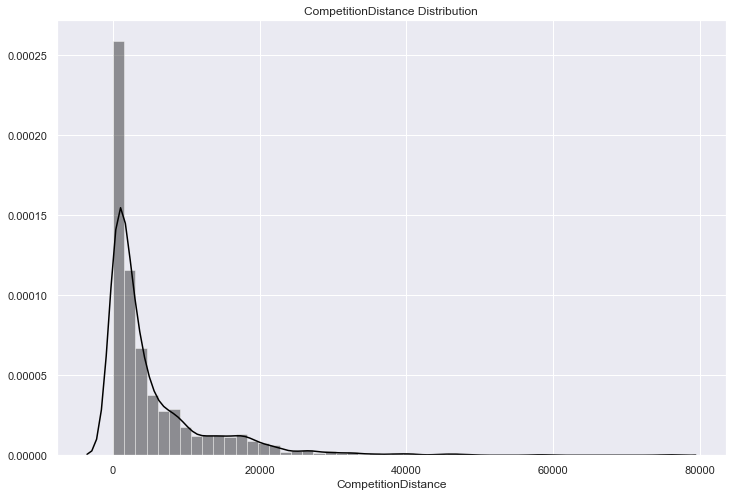

In [23]:
plt.figure(figsize = (12, 8))
sns.distplot(store.CompetitionDistance.dropna(), color = 'black')
plt.title('CompetitionDistance Distribution')

In [24]:
# Median imputation

store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [25]:
def bar(data, column, title) -> Bar:
    c = (
        Bar()
        .add_xaxis(list(data['index']))
        .add_yaxis("", list(data[column]))
        .set_global_opts(title_opts = opts.TitleOpts(title = title))
    )
    return c

In [26]:
CompetitionOpenSinceYear = pd.DataFrame(store['CompetitionOpenSinceYear'].value_counts()).sort_index(ascending = False).reset_index()

c = bar(CompetitionOpenSinceYear, 'CompetitionOpenSinceYear', 'CompetitionOpenSinceYear Distribution')

c.render_notebook()

In [27]:
store[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].fillna(0, inplace = True)

In [28]:
print('Joining train set with an additional store information.')
train_store = pd.merge(train, store, how = 'left', on = 'Store')
print('In total: ', train_store.shape)

Joining train set with an additional store information.
In total:  (844338, 22)


In [29]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [30]:
StoreType = pd.DataFrame(store['StoreType'].value_counts()).sort_index(ascending = False).reset_index()

c = bar(StoreType, 'StoreType', 'StoreType Distribution')

c.render_notebook()

In [31]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [32]:
train_store[train_store.Sales != 0].groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [33]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


In [34]:
np.mean(train_store[(train_store.Month == 1) & (train_store.StoreType == 'b') & (train_store.Promo == 1)])['Sales']

10638.306896551725

In [35]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


### Factor plot